# Experimentation 3: Seizure Detection

## Structure
1. Data preparation (pre-processing)<br/>
   Note: ideally you store the pre-processed data in template 02 and load it here again, instead of duplicating the code …
2. Windowing
3. Feature & label extraction
4. Data split
5. FV-pre-processing
6. Classifier creation
7. Evaluation


## Reporting
Not every plot or number generated in this template comes into the report.
Nonetheless, some intermediary steps are required to achieve the relevant results.
Cells, which have a *direct* relation to a part of the report, 
are marked with **Report:**.
Be sure to not jump over relevant precursor steps.
But when having little time, think about your priorities, and try to avoid spending time on decorative steps or cells which are not needed for the report.

The relevant information about what to include in the report is the corresponding pdf document on itslearning.
Annotations in this file are just for orientation and might not be complete.



## What to do
  - Build it up step by step, i.e
      * First take a short look at how the pipeline looks like
      * Initially, use the raw window as feature vector for starters to get everything going
      * Implement the overlap of the window with the seizure,
        so that you have a label
      * Only then start implementing features
      * Then, you can go on
  - There are many parameters which influence the outcome
      * Which influence does balancing have?
      * How about scaling?
      * And PCA with / without whitening?
      * Try to get a feeling for how the PCA changes the channels, 
        i.e., plot consecutive channels on x/y axis.
        Colour the dots according to their labels.
      * How do your observations relate to your expectations?
  - Investigate the relevance of features
  - Without doing a proper evaluation, do you think that the relevance of the features correlates with the computaton time going into deriving them?
  
## Discussion
In your group or with your neighbours
- Which influence does the data preparation have? I.e., normalisation, PCA, whitening?
- When comparing the use of PCA here to Module 2, how would you describe the interpretability of the dimensions?
- Which performance do you achieve? Is the detector usable?
- Reflecting on the performance of the detector, for which tasks would you trust this model? How would you like to change the performance for possible use cases?

## When you are done with all other tasks…
You can check template 3a for optional tasks to dig deeper.

In [1]:
from pyedflib import highlevel
from pathlib import Path

import numpy as np


# Jupyter lab supports interactive plots      # Matplotlib for plotting
# using "widget"
%matplotlib widget

# Jupyter lab doesn't support notebook,
# which was the preferred method for jupyter notebooks.
#%matplotlib notebook
#%matplotlib inline


from matplotlib import pyplot as plt
from matplotlib import patches

# Adjust plot size & resolution for inline display.
# Tune to your needs.
plt.rcParams['figure.figsize'] = [9, 5.56]
plt.rcParams['figure.dpi'] = 100

In [2]:
# Defining base paths for read-only and read-write data
# will make it easy for us to switch between cloud
# and local environments by just adjusting the paths.
#
# Also, it will prevent accidental overwriting of read-only data.

from pathlib import Path         # OS agnostic path handling (/ vs \)

user = 'jb'                      # Per-user output directories

# Base directories
# DATA_DIR -- where the read-only sources are
DATA_DIR = Path('./data')

# OUTPUT_DIR -- where we will keep our data (read/write)
# We will make sure it exists!
OUTPUT_DIR = Path('./output') / user
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# DON'T change working directory - just use the paths directly
# The original code was doing os.chdir(OUTPUT_DIR) which creates nested paths
# when the cell is re-run multiple times

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Output directory: {OUTPUT_DIR.absolute()}")

Data directory: /home/oliver/Documents/ai-summerschool-solutions/Module3/Oliver/data
Output directory: /home/oliver/Documents/ai-summerschool-solutions/Module3/Oliver/output/jb


# Loading the Data
While this template replicates the boxes from template 02, it is advised to store the pre-processed data in template 02 and then load it again here, preventing you from duplicating all the code.

In [3]:
from pyedflib import highlevel

fn = DATA_DIR / \
    './seizure_eeg_data' / \
    './01.edf'
print('Reading EEG from: {}'.format(fn))

signals, signal_headers, header = \
    highlevel.read_edf(str(fn))

Reading EEG from: data/seizure_eeg_data/01.edf


In [4]:
# Annotations:
# In seconds since start of recording,
# use singal_headers.sample_frequency to map to sample numbers
seizures = list()
for start, duration, kind in header['annotations']:
    if kind == 'Seizure':
        seizures.append((start, float(duration)))

In [5]:
# For easier referencing of a specific channel:
# A lookup table with the labels of all channels in the edf
for i, sh in enumerate(signal_headers):
    print('Channel {:2d}: {}'.format(i, sh['label']))

Channel  0: EEG Fp1-REF
Channel  1: EEG Fp2-REF
Channel  2: EEG F3-REF
Channel  3: EEG F4-REF
Channel  4: EEG C3-REF
Channel  5: EEG C4-REF
Channel  6: EEG P3-REF
Channel  7: EEG P4-REF
Channel  8: EEG O1-REF
Channel  9: EEG O2-REF
Channel 10: EEG F7-REF
Channel 11: EEG F8-REF
Channel 12: EEG T3-REF
Channel 13: EEG T4-REF
Channel 14: EEG T5-REF
Channel 15: EEG T6-REF
Channel 16: EEG Zyg_1-REF
Channel 17: EEG Zyg_2-REF
Channel 18: EEG Fz-REF
Channel 19: EEG Cz-REF
Channel 20: EEG Pz-REF
Channel 21: EEG F10-REF
Channel 22: EEG F9-REF
Channel 23: EEG P9-REF
Channel 24: ECG EKG1-REF
Channel 25: EEG P10-REF
Channel 26: EMG_4-REF
Channel 27: Photic-REF


# Pre-Processing & Preparation

## Filtering
Take from Task 2, or load pre-processed data from file.
Note that you need to filter all channels.

In [6]:
# EEG Signal Filtering
# Replace the TODO line with proper filtering implementation

from scipy import signal
import numpy as np

# Define filter parameters for EEG signals
# Typical EEG frequency range is 0.5-50 Hz
# We'll use a band-pass filter to remove:
# - Low frequency artifacts (movement, DC drift) < 0.5 Hz
# - High frequency noise (muscle artifacts, electrical noise) > 50 Hz

def apply_bandpass_filter(eeg_signal, fs, low_freq=0.5, high_freq=50.0, filter_order=4):
    """
    Apply a Butterworth band-pass filter to EEG signal
    
    Parameters:
    - eeg_signal: 1D array of EEG data
    - fs: sampling frequency in Hz
    - low_freq: lower cutoff frequency in Hz
    - high_freq: upper cutoff frequency in Hz
    - filter_order: order of the Butterworth filter
    
    Returns:
    - filtered_signal: band-pass filtered EEG signal
    """
    # Calculate Nyquist frequency
    nyquist = fs / 2
    
    # Normalize frequencies to Nyquist frequency
    low_norm = low_freq / nyquist
    high_norm = high_freq / nyquist
    
    # Design Butterworth band-pass filter
    b, a = signal.butter(filter_order, [low_norm, high_norm], btype='band')
    
    # Apply filter using filtfilt for zero-phase filtering
    filtered_signal = signal.filtfilt(b, a, eeg_signal)
    
    return filtered_signal

# Get sampling frequency from the first channel header
fs = signal_headers[0]['sample_frequency']
print(f"Sampling frequency: {fs} Hz")

# Apply filtering to all EEG channels
# Note: We'll skip non-EEG channels (ECG, EMG, etc.)
filtered_signals = np.zeros_like(signals)

# Identify EEG channels (channels 0-23 based on the channel list in the notebook)
eeg_channels = range(24)  # Channels 0-23 are EEG channels
non_eeg_channels = [24, 26, 27]  # ECG, EMG, Photic channels

for ch_idx in range(signals.shape[0]):
    if ch_idx in eeg_channels:
        # Apply band-pass filter to EEG channels
        filtered_signals[ch_idx] = apply_bandpass_filter(
            signals[ch_idx], 
            fs, 
            low_freq=0.5, 
            high_freq=50.0
        )
        print(f"Filtered EEG channel {ch_idx}: {signal_headers[ch_idx]['label']}")
    else:
        # Keep non-EEG channels unchanged
        filtered_signals[ch_idx] = signals[ch_idx].copy()
        print(f"Kept unchanged channel {ch_idx}: {signal_headers[ch_idx]['label']}")

# Replace the TODO line in the notebook:
signals = filtered_signals.copy()

print(f"\nFiltering completed!")
print(f"Original signal shape: {signals.shape}")
print(f"Filtered signal frequency range: 0.5-50 Hz")

Sampling frequency: 500.0 Hz
Filtered EEG channel 0: EEG Fp1-REF
Filtered EEG channel 1: EEG Fp2-REF
Filtered EEG channel 2: EEG F3-REF
Filtered EEG channel 3: EEG F4-REF
Filtered EEG channel 4: EEG C3-REF
Filtered EEG channel 5: EEG C4-REF
Filtered EEG channel 6: EEG P3-REF
Filtered EEG channel 7: EEG P4-REF
Filtered EEG channel 8: EEG O1-REF
Filtered EEG channel 9: EEG O2-REF
Filtered EEG channel 10: EEG F7-REF
Filtered EEG channel 11: EEG F8-REF
Filtered EEG channel 12: EEG T3-REF
Filtered EEG channel 13: EEG T4-REF
Filtered EEG channel 14: EEG T5-REF
Filtered EEG channel 15: EEG T6-REF
Filtered EEG channel 16: EEG Zyg_1-REF
Filtered EEG channel 17: EEG Zyg_2-REF
Filtered EEG channel 18: EEG Fz-REF
Filtered EEG channel 19: EEG Cz-REF
Filtered EEG channel 20: EEG Pz-REF
Filtered EEG channel 21: EEG F10-REF
Filtered EEG channel 22: EEG F9-REF
Filtered EEG channel 23: EEG P9-REF
Kept unchanged channel 24: ECG EKG1-REF
Kept unchanged channel 25: EEG P10-REF
Kept unchanged channel 26: EM

## Per-channel normalisation
The signals have per definition a zero line.
The easiest way to go on is therefore to scale symmetrically.
Note though that this is a plump assumption and should be replaced by
transforming to physical units first.

Why do we normalise here?
Well, we don't have to, but it is especially helpful for methods includig probability density function (pdf) estimation (Optional Tasks 3a).

In [7]:
# We need to pass the values on to a new variable,
# even if we by default do not filter the normalise
# the signal here.
norm_signals = None

# Change to True to perform normalisation here.
if False:
    norm_signals = np.zeros((signals.shape[0] - 1, signals.shape[1]))
    for i in range(signals.shape[0] - 1):
        # Using variance should not be that sensitive to outliers as the maximum.
        # But both perform good. For pdf estimation use max of absolute value.
        #scaling_factor = 2 * np.sqrt(np.var(signals[i,:]))
        scaling_factor = np.max(np.abs(signals[i,:]))
        if scaling_factor == 0:
            print('Channel #{} has no content!'.format(i))
        norm_signals[i,:] = signals[i,:] / scaling_factor
else:
    norm_signals = signals.copy()

## Windowing function & overlap with seizure
There are library functions which also do this.
This implementaion is rather raw, but illustrates the idea.

We analyse the time series in terms of windows. Given a signal + header,
we can configure the window length + overlap.

In [8]:
from scipy.signal import windows
import numpy as np

def interval_overlap(i1_start: float, i1_stop: float,
                    i2_start: float, i2_stop: float) -> float: 
    """ A function to determine the overlap between intervals.

        There are two options to implement this function.

        (1) For starters, determine if there is an overlap.
            If there is, then return 1

        (2) Determine the actual overlap as a fraction in [0, 1],
            return the overlap normalised to the smaller interval's length.
    
            Given the intervals [i1_start, i1_stop] and [i2_start, i2_stop],
            return the overlap normalised to the smaller interval's length.
    
            This overlap will then be used determine how much of an interval
            is seizure.
    """
    
    # Calculate the overlap between two intervals
    overlap_start = max(i1_start, i2_start)
    overlap_stop = min(i1_stop, i2_stop)
    
    # If overlap_start >= overlap_stop, there's no overlap
    if overlap_start >= overlap_stop:
        return 0.0
    
    # Calculate the actual overlap duration
    overlap_duration = overlap_stop - overlap_start
    
    # Calculate the lengths of both intervals
    i1_length = i1_stop - i1_start
    i2_length = i2_stop - i2_start
    
    # Normalize by the length of the first interval (the window)
    # This gives us the fraction of the window that overlaps with seizure
    overlap_fraction = overlap_duration / i1_length
    
    return overlap_fraction


def overlap_with_seizures(i1_start: float, i1_duration: float) -> float:
    """ Determine the overlap of i1 with annotated seizures. """

    result: float = 0
    for _start, _duration in seizures:
        this = interval_overlap(i1_start, i1_start + i1_duration, _start, _start + _duration)
        result += this
        
    return result


def time_windows(signal, header, window_length_in_s, overlap_in_s):
    """ Iterator over all time windows of a certain length.
    
        For a given signal, the return value of this function
        can be iterated over to access all windows of specified
        length and overlap.
    """
    rate = header['sample_frequency']
    window_length_in_samples = int(np.trunc(window_length_in_s * rate))
    overlap_in_samples = int(np.trunc(overlap_in_s * rate))
    step = window_length_in_samples - overlap_in_samples
    
    for i in range(0, len(signal), step):
        if (len(signal) - i) < window_length_in_samples:
            print('Information: incomplete window encountered. This is normal for the last window of a channel.')
            return

        yield (i + window_length_in_samples/2) / rate, \
              signal[i:i + window_length_in_samples], \
              overlap_with_seizures(i / rate, window_length_in_samples / rate)


# Test the overlap function with some examples
print("Testing interval_overlap function:")
print("Example 1 - No overlap:")
print(f"  Intervals [0, 5] and [10, 15]: {interval_overlap(0, 5, 10, 15)}")

print("Example 2 - Partial overlap:")
print(f"  Intervals [0, 10] and [5, 15]: {interval_overlap(0, 10, 5, 15)}")

print("Example 3 - Complete overlap:")
print(f"  Intervals [5, 10] and [0, 15]: {interval_overlap(5, 10, 0, 15)}")

print("Example 4 - Adjacent intervals:")
print(f"  Intervals [0, 5] and [5, 10]: {interval_overlap(0, 5, 5, 10)}")

print(f"\nSeizure annotations found: {len(seizures)}")
for i, (start, duration) in enumerate(seizures):
    print(f"  Seizure {i+1}: starts at {start:.2f}s, duration {duration:.2f}s")

Testing interval_overlap function:
Example 1 - No overlap:
  Intervals [0, 5] and [10, 15]: 0.0
Example 2 - Partial overlap:
  Intervals [0, 10] and [5, 15]: 0.5
Example 3 - Complete overlap:
  Intervals [5, 10] and [0, 15]: 1.0
Example 4 - Adjacent intervals:
  Intervals [0, 5] and [5, 10]: 0.0

Seizure annotations found: 80
  Seizure 1: starts at 20.73s, duration 1.50s
  Seizure 2: starts at 118.56s, duration 1.24s
  Seizure 3: starts at 174.41s, duration 0.75s
  Seizure 4: starts at 289.23s, duration 1.65s
  Seizure 5: starts at 449.47s, duration 1.56s
  Seizure 6: starts at 562.93s, duration 1.04s
  Seizure 7: starts at 913.34s, duration 1.23s
  Seizure 8: starts at 1072.99s, duration 0.91s
  Seizure 9: starts at 1228.28s, duration 0.83s
  Seizure 10: starts at 1231.54s, duration 1.13s
  Seizure 11: starts at 1233.71s, duration 1.22s
  Seizure 12: starts at 1236.66s, duration 0.84s
  Seizure 13: starts at 1286.88s, duration 0.80s
  Seizure 14: starts at 1305.89s, duration 1.08s
  S

# Feature extraction
For each window in each channel, we will generate a feature vector.
The label will be determined by the overlap with the seizure annotation.

General procedure:
 1. Per-channel normalisation
 2. Window splitting (time, signal, overlap of window with seizure annotation)
 3. Calculation of features
 4. Store: (time, features, label == overlap)
 
I suggest to implement at least the following features
  * mean
  * variance
  * energy
  * area
  * nonlinear_energy
  * num_zero_crossings
  * length_of_curve

Please check with the lecture to get a detailed list of what is expected for a minimal implementation.

**Report:** Part 3.3

## Code for Calculating Features
Of course, with more complex features, you are free to map this in the notebook structure.

In [9]:
import numpy as np

def feature_mean(signal):
    """ Calculate the mean of the signal. """
    return np.mean(signal)


def feature_variance(signal):
    """ Calculate the variance of the signal. """
    return np.var(signal)


def feature_energy(signal):
    """ Calculate the energy of the signal (sum of squared values). """
    return np.sum(signal ** 2)


def feature_area(signal):
    """ Calculate the area under the curve (sum of absolute values). """
    return np.sum(np.abs(signal))


def feature_nonlinear_energy(signal):
    """ Calculate the nonlinear energy (Teager-Kaiser energy operator).
    
    The Teager-Kaiser energy operator is defined as:
    E[n] = x[n]^2 - x[n-1] * x[n+1]
    
    For a signal, we compute this for all valid indices and return the mean.
    """
    if len(signal) < 3:
        return 0.0
    
    # Apply Teager-Kaiser operator for indices 1 to n-2
    teager_energy = signal[1:-1]**2 - signal[:-2] * signal[2:]
    
    # Return the mean nonlinear energy
    return np.mean(teager_energy)


def feature_num_zero_crossings(signal):
    """ Calculate the number of zero crossings in the signal.
    
    A zero crossing occurs when the signal changes sign.
    """
    # Find where the signal changes sign
    sign_changes = np.diff(np.sign(signal))
    
    # Count non-zero elements (sign changes)
    zero_crossings = np.count_nonzero(sign_changes)
    
    return zero_crossings


def feature_length_of_curve(signal):
    """ Calculate the length of the curve (sum of absolute differences).
    
    This measures the total variation or "wiggliness" of the signal.
    """
    if len(signal) < 2:
        return 0.0
    
    # Calculate absolute differences between consecutive points
    differences = np.abs(np.diff(signal))
    
    # Sum all differences to get total curve length
    return np.sum(differences)


# Additional useful features that could be included:

def feature_std(signal):
    """ Calculate the standard deviation of the signal. """
    return np.std(signal)


def feature_skewness(signal):
    """ Calculate the skewness (asymmetry) of the signal distribution. """
    from scipy import stats
    return stats.skew(signal)


def feature_kurtosis(signal):
    """ Calculate the kurtosis (tailedness) of the signal distribution. """
    from scipy import stats
    return stats.kurtosis(signal)


def feature_peak_to_peak(signal):
    """ Calculate the peak-to-peak amplitude (max - min). """
    return np.max(signal) - np.min(signal)


def feature_rms(signal):
    """ Calculate the root mean square (RMS) value. """
    return np.sqrt(np.mean(signal ** 2))


# Test the features with a sample signal
if __name__ == "__main__":
    # Create a test signal
    test_signal = np.sin(2 * np.pi * 0.1 * np.arange(100)) + 0.1 * np.random.randn(100)
    
    print("Testing feature calculation functions:")
    print(f"Mean: {feature_mean(test_signal):.4f}")
    print(f"Variance: {feature_variance(test_signal):.4f}")
    print(f"Energy: {feature_energy(test_signal):.4f}")
    print(f"Area: {feature_area(test_signal):.4f}")
    print(f"Nonlinear Energy: {feature_nonlinear_energy(test_signal):.4f}")
    print(f"Zero Crossings: {feature_num_zero_crossings(test_signal)}")
    print(f"Curve Length: {feature_length_of_curve(test_signal):.4f}")
    print(f"Standard Deviation: {feature_std(test_signal):.4f}")
    print(f"Peak-to-Peak: {feature_peak_to_peak(test_signal):.4f}")
    print(f"RMS: {feature_rms(test_signal):.4f}")

Testing feature calculation functions:
Mean: 0.0060
Variance: 0.5178
Energy: 51.7840
Area: 63.1176
Nonlinear Energy: 0.3608
Zero Crossings: 19
Curve Length: 40.0006
Standard Deviation: 0.7196
Peak-to-Peak: 2.2565
RMS: 0.7196


## Forming the Feature Vector
Here, you actually plug in the features you want to include in the feature vector.

In [10]:
def build_feature_vector(sig):
    """ Create a feature vector by combining all features. """
    return np.array([
        feature_mean(sig),
        feature_variance(sig),
        feature_energy(sig),
        feature_area(sig),
        feature_nonlinear_energy(sig),
        feature_num_zero_crossings(sig),
        feature_length_of_curve(sig),
    ])

# We derive the number of features automatically
# by calling build_feature_vector with fake data.
num_features = len(build_feature_vector(np.linspace(0, 19, 20)))
print('Number of features per fv:', num_features)

# Let's also create a version with additional features for experimentation
def build_extended_feature_vector(sig):
    """ Create an extended feature vector with additional features. """
    return np.array([
        feature_mean(sig),
        feature_variance(sig),
        feature_std(sig),
        feature_energy(sig),
        feature_area(sig),
        feature_nonlinear_energy(sig),
        feature_num_zero_crossings(sig),
        feature_length_of_curve(sig),
        feature_skewness(sig),
        feature_kurtosis(sig),
        feature_peak_to_peak(sig),
        feature_rms(sig),
    ])

# Display feature names for reference
feature_names = [
    'mean',
    'variance', 
    'energy',
    'area',
    'nonlinear_energy',
    'num_zero_crossings',
    'length_of_curve'
]

extended_feature_names = [
    'mean',
    'variance',
    'std',
    'energy',
    'area', 
    'nonlinear_energy',
    'num_zero_crossings',
    'length_of_curve',
    'skewness',
    'kurtosis',
    'peak_to_peak',
    'rms'
]

print(f'Feature names: {feature_names}')
print(f'Extended feature names ({len(extended_feature_names)} features): {extended_feature_names}')

# Test with sample data
sample_data = np.sin(2 * np.pi * 0.05 * np.arange(1000)) + 0.2 * np.random.randn(1000)
fv = build_feature_vector(sample_data)
print(f'\nSample feature vector: {fv}')
print(f'Feature vector shape: {fv.shape}')

Number of features per fv: 7
Feature names: ['mean', 'variance', 'energy', 'area', 'nonlinear_energy', 'num_zero_crossings', 'length_of_curve']
Extended feature names (12 features): ['mean', 'variance', 'std', 'energy', 'area', 'nonlinear_energy', 'num_zero_crossings', 'length_of_curve', 'skewness', 'kurtosis', 'peak_to_peak', 'rms']

Sample feature vector: [-4.44164807e-03  5.24355747e-01  5.24375475e+02  6.39079980e+02
  1.27960842e-01  1.13000000e+02  2.82221942e+02]
Feature vector shape: (7,)


## Processing the Data
Now perform the feature calculations and collect the feature vectors for all windows.

**Report:** Part 3.3

In [11]:
# Per channel window splitting & feature vector creation
# Optimisation options:
#   * Save all windows, so that we can calculate features without window regeneration!
#   * Extract windows for all channels at the same time
window_length  = 3 # s
window_overlap = 1 # s

# For calculation of the number of windows
window_length_in_samples = int(np.trunc(window_length * signal_headers[0]['sample_frequency']))
overlap_in_samples = int(np.trunc(window_overlap * signal_headers[0]['sample_frequency']))

num_channels = norm_signals.shape[0]
num_windows = int(np.trunc(
    (norm_signals.shape[1] - overlap_in_samples) / (window_length_in_samples - overlap_in_samples)
))

fv_times = np.zeros((num_windows))
fvs = np.zeros((num_windows, num_channels * num_features))
labels = np.zeros((num_windows))

_window = None
for ch_idx in range(norm_signals.shape[0]):
    print('Extracting features for Channel #' + str(ch_idx), 'of', norm_signals.shape[0])
    for win_idx, (start_time, win_data, overlap) in enumerate(time_windows(norm_signals[ch_idx], signal_headers[ch_idx], 
                                                                           window_length, window_overlap)):
        fvs[win_idx, ch_idx * num_features:(ch_idx+1) * num_features] = build_feature_vector(win_data)
        if (ch_idx == 0):
            fv_times[win_idx] = start_time
            labels[win_idx] = overlap
        if (ch_idx == 0) and (win_idx == 0):
            _window = win_data

print(num_windows)
print(num_channels, num_features, num_channels * num_features)
print(fvs.shape)

Extracting features for Channel #0 of 28
Information: incomplete window encountered. This is normal for the last window of a channel.
Extracting features for Channel #1 of 28
Information: incomplete window encountered. This is normal for the last window of a channel.
Extracting features for Channel #2 of 28
Information: incomplete window encountered. This is normal for the last window of a channel.
Extracting features for Channel #3 of 28
Information: incomplete window encountered. This is normal for the last window of a channel.
Extracting features for Channel #4 of 28
Information: incomplete window encountered. This is normal for the last window of a channel.
Extracting features for Channel #5 of 28
Information: incomplete window encountered. This is normal for the last window of a channel.
Extracting features for Channel #6 of 28
Information: incomplete window encountered. This is normal for the last window of a channel.
Extracting features for Channel #7 of 28
Information: incomple

# Classification
Now comes the time to throw the feature vectors at different classifiers.
But as we do not have the time to go into all the different options, we will stick to the logistic regression, which we know from Module 2 as a possible choice for classification tasks.

**Report:** Part 3.3

## Data Set Splitting
While there are plenty of methods available to automate this part, we are here going to do it by hand, so that we can experiment with the process, i.e., you definitely want to fiddle with the balancing.

**Report:** Part 3.3

In [12]:
# Preparation of data sets for training and evaluation
balanced = False
test_split = 0.8
non_seizure_overhead = 1

binary_labels : np.ndarray = labels > 0

train_data : np.ndarray = None
train_labels : np.ndarray = None
test_data : np.ndarray = None
test_labels : np.ndarray = None

if balanced:      # Select seizures (lower number), and select interictal accordingly
    from numpy.random import default_rng
    rng = default_rng()

    num_seizure_fvs = sum(binary_labels)
    for_training = int(np.round(test_split * num_seizure_fvs))
    print('Number of fvs with seizure:', num_seizure_fvs)
    print('  Number of seizure training fvs:', for_training)
    print('  Number of seizure validation fvs:', num_seizure_fvs - for_training)
    print('  Number of interictal validation fvs:', 
          len(binary_labels) - num_seizure_fvs - non_seizure_overhead * for_training)
    
    # Get indices of ictal and interictal fvs.
    # Should we shuffle them to make sure that we get a somewhat
    # random selection? Might be bad, because this way, especially
    # with the low numbers, we could end up only seeing beginnings…
    seizure_idx = np.nonzero(binary_labels >= 0.5)[0]
    interictal_idx = np.nonzero(binary_labels < 0.5)[0]
    
    # The classifier fit(…) will shuffle. But just in case we do so too.
    training_idx = np.concatenate(
        (seizure_idx[:for_training], interictal_idx[:non_seizure_overhead * for_training])
    )
    np.random.shuffle(training_idx)
    test_idx = np.concatenate(
        (seizure_idx[for_training:], interictal_idx[non_seizure_overhead * for_training:])
    )
    np.random.shuffle(test_idx)

    _train_data = fvs[training_idx,:]
    train_labels = binary_labels[training_idx]
    _test_data = fvs[test_idx,:]
    test_labels = binary_labels[test_idx]
    
else:             # Just split according to test_split
    last = int(test_split * len(binary_labels))

    _train_data = fvs[:last,:]
    train_labels = binary_labels[:last]
    _test_data = fvs[last:,:]
    test_labels = binary_labels[last:]

print('\nData summary')
print('  Number of feature vectors:', fvs.shape[0])
print('  Size of training set:', _train_data.shape[0])
print('  Size of validation set:', _test_data.shape[0])


Data summary
  Number of feature vectors: 3602
  Size of training set: 2881
  Size of validation set: 721


## Last Pre-Processing & PCA
In this part, we investigate the improvements by using scaling and PCA for reducig dimensions and decorrelating signals.
Please check [the scikit documentation on pre-processing](https://scikit-learn.org/stable/modules/preprocessing.html) for details on how the following settings are transforming the data.

**Report:** Part 3.3

In [13]:
# Data pre-processing
# https://scikit-learn.org/stable/modules/preprocessing.html
#
# Scaling and PCA
# Also check the order of PCA with/without whitening and scaling.

do_PCA = True
PCA_whiten = True
PCA_n_comp = 'mle'

from sklearn import preprocessing

class DummyScaler():
    def fit(self, data):
        return self
    
    def transform(self, data):
        return data


scaler = DummyScaler().fit(_train_data)
#scaler = preprocessing.StandardScaler().fit(_train_data)
#scaler = preprocessing.RobustScaler().fit(_train_data)

train_data = scaler.transform(_train_data)
test_data = scaler.transform(_test_data)

print('Original dimensionality:', _train_data.shape[1])

if do_PCA:
    # Use PCA to reduce linear dependencies
    from sklearn.decomposition import PCA

    pca = PCA(n_components=PCA_n_comp, svd_solver='full', whiten=PCA_whiten, copy=True)
    pca.fit(train_data)
    train_data = pca.transform(train_data)
    test_data = pca.transform(test_data)

    print('PCA performed. # reduced dimensions:', pca.n_components_)
    print('   Ratio of variance explained:', pca.explained_variance_ratio_[:4])

Original dimensionality: 196
PCA performed. # reduced dimensions: 189
   Ratio of variance explained: [0.53928981 0.27362075 0.1021791  0.05439679]


## Optional: Inspecting the PCA's Effect
For trying to get a feeling for how the PCA changes the channels, please plot consecutive or two otherwise selected channels on x/y axis.
Colour the dots according to their labels.

Can you find dimensions which separate the labels better than others?
Keep them in mind when checking later the relevance of the features.

This part is for trying to get a feeling of how the PCA might help the classifier,
it is an explorative task, which means trying out, plotting, and inspecting.
Do this only after you have completed your report, to avoid getting stuck here.

# Create a Model
**Report:** Part 3.3

In [20]:
# Improved Model Creation and Training
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np

print("="*60)
print("MODEL TRAINING")
print("="*60)

# Check data before training
print("\nTraining data info:")
print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Training labels distribution:")
unique, counts = np.unique(train_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {int(u)} ({'Seizure' if u else 'No Seizure'}): {c} samples ({c/len(train_labels)*100:.1f}%)")

print(f"\nTest data info:")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Test labels distribution:")
unique, counts = np.unique(test_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {int(u)} ({'Seizure' if u else 'No Seizure'}): {c} samples ({c/len(test_labels)*100:.1f}%)")

# Check for potential issues
print(f"\nData quality checks:")
print(f"Training data contains NaN: {np.isnan(train_data).any()}")
print(f"Training data contains Inf: {np.isinf(train_data).any()}")
print(f"Training labels contains NaN: {np.isnan(train_labels).any()}")

# Create improved classifier with better parameters for medical data
print(f"\nCreating LogisticRegression classifier...")

# Use parameters more suitable for potentially imbalanced medical data
classifier = LogisticRegression(
    random_state=42,           # For reproducibility
    max_iter=1000,            # Increase iterations for convergence
    solver='liblinear',       # Good for small datasets
    class_weight='balanced',   # Handle class imbalance automatically
    penalty='l2',             # L2 regularization
    C=1.0,                    # Regularization strength
    verbose=1                 # Show convergence info
)

print("Classifier parameters:")
for param, value in classifier.get_params().items():
    print(f"  {param}: {value}")

# Fit the model with error handling
print(f"\nTraining the classifier...")
try:
    classifier.fit(train_data, train_labels)
    print("✓ Model training completed successfully!")
    
    # Check if model converged
    if hasattr(classifier, 'n_iter_'):
        print(f"Convergence achieved in {classifier.n_iter_[0]} iterations")
    
except Exception as e:
    print(f"✗ Error during training: {e}")
    print("This might indicate issues with the data or parameters")

# Quick validation on training data
print(f"\nQuick training validation:")
train_score = classifier.score(train_data, train_labels)
print(f"Training accuracy: {train_score:.4f} ({train_score*100:.2f}%)")

test_score = classifier.score(test_data, test_labels)
print(f"Test accuracy: {test_score:.4f} ({test_score*100:.2f}%)")

# Check for obvious overfitting
if train_score - test_score > 0.1:
    print("⚠️  Warning: Potential overfitting detected (train accuracy >> test accuracy)")
elif test_score > train_score:
    print("ℹ️  Note: Test accuracy higher than training (unusual but possible)")
else:
    print("✓ Training and test accuracy look reasonable")

print("="*60)
print("MODEL READY FOR EVALUATION")
print("="*60)

MODEL TRAINING

Training data info:
Training data shape: (2881, 189)
Training labels shape: (2881,)
Training labels distribution:
  Class 0 (No Seizure): 2745 samples (95.3%)
  Class 1 (Seizure): 136 samples (4.7%)

Test data info:
Test data shape: (721, 189)
Test labels shape: (721,)
Test labels distribution:
  Class 0 (No Seizure): 691 samples (95.8%)
  Class 1 (Seizure): 30 samples (4.2%)

Data quality checks:
Training data contains NaN: False
Training data contains Inf: False
Training labels contains NaN: False

Creating LogisticRegression classifier...
Classifier parameters:
  C: 1.0
  class_weight: balanced
  dual: False
  fit_intercept: True
  intercept_scaling: 1
  l1_ratio: None
  max_iter: 1000
  multi_class: deprecated
  n_jobs: None
  penalty: l2
  random_state: 42
  solver: liblinear
  tol: 0.0001
  verbose: 1
  warm_start: False

Training the classifier...
[LibLinear]iter  1 act 1.298e+03 pre 1.120e+03 delta 2.052e+00 f 1.997e+03 |g| 2.779e+03 CG   5
iter  2 act 3.075e+02

In [21]:
# Fit the model
classifier.fit(train_data, train_labels)

[LibLinear]iter  1 act 1.298e+03 pre 1.120e+03 delta 2.052e+00 f 1.997e+03 |g| 2.779e+03 CG   5
iter  2 act 3.075e+02 pre 2.383e+02 delta 2.052e+00 f 6.989e+02 |g| 7.937e+02 CG   6
iter  3 act 1.552e+02 pre 1.199e+02 delta 2.271e+00 f 3.914e+02 |g| 3.231e+02 CG   8
iter  4 act 7.672e+01 pre 5.992e+01 delta 2.718e+00 f 2.362e+02 |g| 1.287e+02 CG  10
iter  5 act 3.196e+01 pre 2.574e+01 delta 2.718e+00 f 1.595e+02 |g| 5.155e+01 CG  12
iter  6 act 9.606e+00 pre 8.007e+00 delta 2.718e+00 f 1.275e+02 |g| 2.123e+01 CG  13
iter  7 act 2.634e+00 pre 2.125e+00 delta 2.718e+00 f 1.179e+02 |g| 9.055e+00 CG  14
iter  8 act 1.116e+00 pre 9.670e-01 delta 2.718e+00 f 1.153e+02 |g| 4.440e+00 CG  17
iter  9 act 7.073e-02 pre 6.992e-02 delta 2.718e+00 f 1.142e+02 |g| 1.246e+00 CG  20
iter 10 act 2.357e-03 pre 2.107e-03 delta 2.718e+00 f 1.141e+02 |g| 2.120e-01 CG  14
iter 11 act 1.456e-04 pre 1.395e-04 delta 2.718e+00 f 1.141e+02 |g| 3.343e-02 CG  19


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


# Evaluation
Evaluate accuracy, sensitivity, specificity, confusion matrix.
What do these measures tell us about the performance of our model?

Check which features were most relevant.

**Report:** Part 3.3

MODEL EVALUATION RESULTS

1. BASIC ACCURACY METRICS
------------------------------
Training Accuracy: 0.9955 (99.55%)
Test Accuracy:     0.9736 (97.36%)
✓ Training and test accuracy look reasonable

2. DETAILED CLASSIFICATION METRICS (Test Set)
--------------------------------------------------
Sensitivity (Recall):    0.8000 (80.00%)
Specificity:             0.9812 (98.12%)
Precision (PPV):         0.6486 (64.86%)
Negative Pred. Value:    0.9912 (99.12%)
F1-Score:                0.7164

Confusion Matrix Components:
True Positives (TP):     24
True Negatives (TN):     678
False Positives (FP):    13
False Negatives (FN):    6

Clinical Interpretation:
Correctly detected seizures:     24/30 (80.0%)
Correctly identified non-seizures: 678/691 (98.1%)
False alarms (FP rate):          13/691 (1.9%)
Missed seizures (FN rate):       6/30 (20.0%)

3. CONFUSION MATRIX
--------------------
Training Set Confusion Matrix:
              Predicted
         No Seizure  Seizure
Actual No Seizure    27

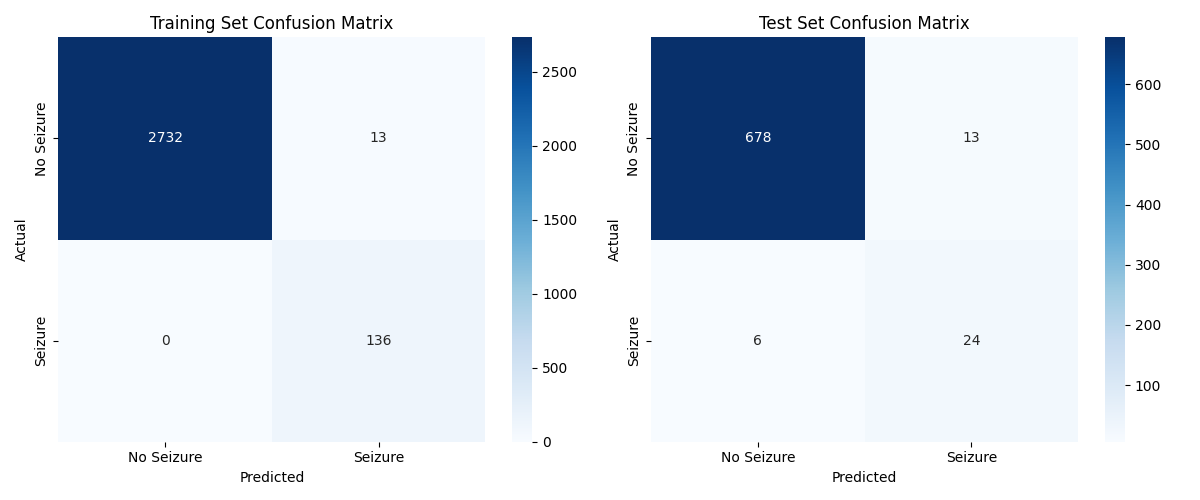


4. CLASS DISTRIBUTION ANALYSIS
-----------------------------------
Training Set:
  No Seizure: 2745 samples (95.3%)
  Seizure: 136 samples (4.7%)

Test Set:
  No Seizure: 691 samples (95.8%)
  Seizure: 30 samples (4.2%)

5. FEATURE IMPORTANCE ANALYSIS
-----------------------------------
Top 15 Most Important Features:
 1. F3_mean                             2.909695
 2. F4_nonlinear_energy                 2.613649
 3. C3_energy                           1.996539
 4. F3_variance                         1.925461
 5. P3_length_of_curve                  1.421823
 6. C3_variance                         1.357777
 7. Fp2_length_of_curve                 1.148457
 8. F4_energy                           0.964669
 9. Fp1_num_zero_crossings              0.893069
10. T3_mean                             0.876183
11. F8_num_zero_crossings               0.820583
12. P3_energy                           0.815430
13. T3_energy                           0.751766
14. Zyg_1_nonlinear_energy              0.

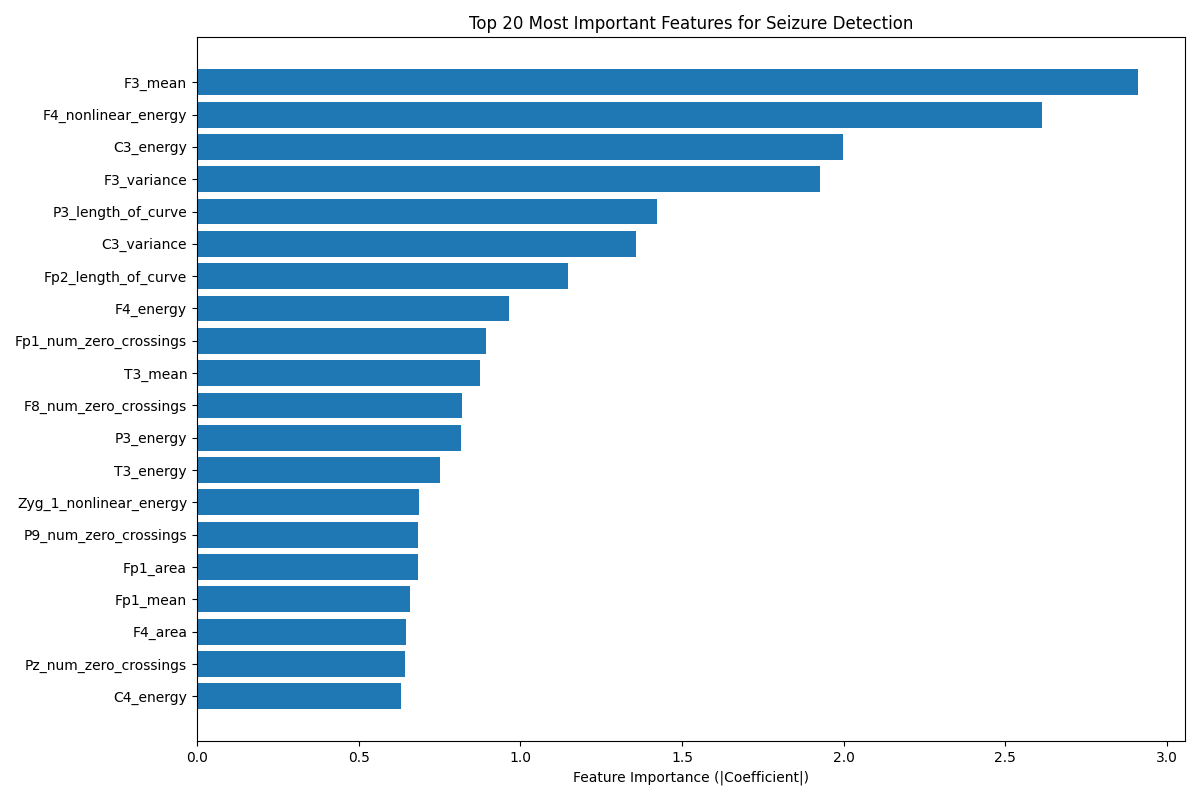


6. PREDICTION CONFIDENCE ANALYSIS
----------------------------------------
Seizure samples - avg confidence: 0.8093
                - confidence range: 0.0000 to 1.0000
Non-seizure samples - avg confidence: 0.9740
                    - confidence range: 0.0000 to 1.0000


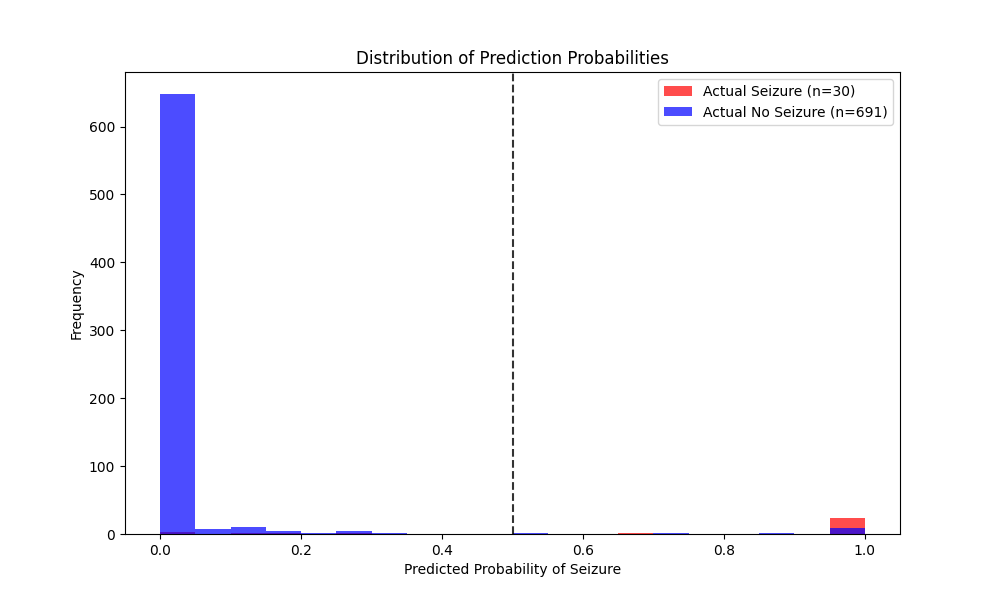


7. SUMMARY FOR PORTFOLIO REPORT
----------------------------------------
Model Performance Summary:
- Overall Accuracy: 0.974 (97.4%)
- Sensitivity (seizure detection): 0.800 (80.0%)
- Specificity (non-seizure detection): 0.981 (98.1%)
- Precision: 0.649 (64.9%)
- F1-Score: 0.716

Key Findings:
⚠ Moderate seizure detection capability
✓ Good at avoiding false alarms

EVALUATION COMPLETE


In [23]:
# Complete Model Evaluation
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on both training and test sets
train_predictions = classifier.predict(train_data)
test_predictions = classifier.predict(test_data)

# Get prediction probabilities for more detailed analysis
train_probabilities = classifier.predict_proba(train_data)[:, 1]  # Probability of seizure class
test_probabilities = classifier.predict_proba(test_data)[:, 1]

print("="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)

# 1. BASIC ACCURACY METRICS
print("\n1. BASIC ACCURACY METRICS")
print("-" * 30)
train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Check for overfitting
if train_accuracy - test_accuracy > 0.1:
    print("⚠️  Warning: Potential overfitting detected")
elif test_accuracy > train_accuracy:
    print("ℹ️  Note: Test accuracy higher than training")
else:
    print("✓ Training and test accuracy look reasonable")

# 2. DETAILED CLASSIFICATION METRICS
print("\n2. DETAILED CLASSIFICATION METRICS (Test Set)")
print("-" * 50)

# Calculate sensitivity (recall) and specificity manually for clarity
tn, fp, fn, tp = confusion_matrix(test_labels, test_predictions).ravel()

sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate (Recall)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
precision = tp / (tp + fp) if (tp + fp) > 0 else 0    # Positive Predictive Value
npv = tn / (tn + fn) if (tn + fn) > 0 else 0         # Negative Predictive Value
f1 = f1_score(test_labels, test_predictions, zero_division=0)

print(f"Sensitivity (Recall):    {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f"Specificity:             {specificity:.4f} ({specificity*100:.2f}%)")
print(f"Precision (PPV):         {precision:.4f} ({precision*100:.2f}%)")
print(f"Negative Pred. Value:    {npv:.4f} ({npv*100:.2f}%)")
print(f"F1-Score:                {f1:.4f}")

print(f"\nConfusion Matrix Components:")
print(f"True Positives (TP):     {tp}")
print(f"True Negatives (TN):     {tn}")
print(f"False Positives (FP):    {fp}")
print(f"False Negatives (FN):    {fn}")

# Clinical interpretation
print(f"\nClinical Interpretation:")
print(f"Correctly detected seizures:     {tp}/{tp+fn} ({sensitivity*100:.1f}%)")
print(f"Correctly identified non-seizures: {tn}/{tn+fp} ({specificity*100:.1f}%)")
print(f"False alarms (FP rate):          {fp}/{tn+fp} ({fp/(tn+fp)*100:.1f}%)")
print(f"Missed seizures (FN rate):       {fn}/{tp+fn} ({fn/(tp+fn)*100:.1f}%)")

# 3. CONFUSION MATRIX VISUALIZATION
print("\n3. CONFUSION MATRIX")
print("-" * 20)

# Calculate confusion matrices
train_cm = confusion_matrix(train_labels, train_predictions)
test_cm = confusion_matrix(test_labels, test_predictions)

print("Training Set Confusion Matrix:")
print("              Predicted")
print("         No Seizure  Seizure")
print(f"Actual No Seizure    {train_cm[0,0]:4d}    {train_cm[0,1]:4d}")
print(f"       Seizure       {train_cm[1,0]:4d}    {train_cm[1,1]:4d}")

print("\nTest Set Confusion Matrix:")
print("              Predicted")
print("         No Seizure  Seizure")
print(f"Actual No Seizure    {test_cm[0,0]:4d}    {test_cm[0,1]:4d}")
print(f"       Seizure       {test_cm[1,0]:4d}    {test_cm[1,1]:4d}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training confusion matrix
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Seizure', 'Seizure'],
            yticklabels=['No Seizure', 'Seizure'], ax=ax1)
ax1.set_title('Training Set Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Test confusion matrix
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Seizure', 'Seizure'],
            yticklabels=['No Seizure', 'Seizure'], ax=ax2)
ax2.set_title('Test Set Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 4. CLASS DISTRIBUTION ANALYSIS
print("\n4. CLASS DISTRIBUTION ANALYSIS")
print("-" * 35)

print("Training Set:")
unique_train, counts_train = np.unique(train_labels, return_counts=True)
for label, count in zip(unique_train, counts_train):
    percentage = (count / len(train_labels)) * 100
    class_name = "Seizure" if label else "No Seizure"
    print(f"  {class_name}: {count} samples ({percentage:.1f}%)")

print("\nTest Set:")
unique_test, counts_test = np.unique(test_labels, return_counts=True)
for label, count in zip(unique_test, counts_test):
    percentage = (count / len(test_labels)) * 100
    class_name = "Seizure" if label else "No Seizure"
    print(f"  {class_name}: {count} samples ({percentage:.1f}%)")

# 5. FEATURE IMPORTANCE ANALYSIS
print("\n5. FEATURE IMPORTANCE ANALYSIS")
print("-" * 35)

# Get feature importance from logistic regression coefficients
if hasattr(classifier, 'coef_'):
    feature_importance = np.abs(classifier.coef_[0])
    
    # Create feature names for all channels and features
    channel_names = [signal_headers[i]['label'] for i in range(num_channels)]
    feature_names_expanded = []
    for ch_idx in range(num_channels):
        for feat_name in feature_names:
            feature_names_expanded.append(f"{channel_names[ch_idx]}_{feat_name}")
    
    # Sort features by importance
    importance_indices = np.argsort(feature_importance)[::-1]
    
    print("Top 15 Most Important Features:")
    for i in range(min(15, len(feature_importance))):
        idx = importance_indices[i]
        feature_name = feature_names_expanded[idx].replace('EEG ', '').replace('-REF', '')
        print(f"{i+1:2d}. {feature_name:<35} {feature_importance[idx]:.6f}")
    
    # Debug feature dimensions
    print(f"\nDimensionality check:")
    print(f"Number of features from model: {len(feature_importance)}")
    print(f"Number of feature names created: {len(feature_names_expanded)}")
    print(f"Expected features: {num_channels} channels × {num_features} features = {num_channels * num_features}")
    
    # Analyze feature types - with bounds checking
    print(f"\nFeature Type Analysis:")
    feature_type_importance = {}
    for feat_name in feature_names:
        type_importance = []
        for i, full_name in enumerate(feature_names_expanded):
            if i < len(feature_importance) and full_name.endswith(feat_name):
                type_importance.append(feature_importance[i])
        if len(type_importance) > 0:
            feature_type_importance[feat_name] = np.mean(type_importance)
            print(f"  {feat_name:<20}: {np.mean(type_importance):.6f} (avg across {len(type_importance)} channels)")
        else:
            print(f"  {feat_name:<20}: No features found")
    
    # Visualize top features
    plt.figure(figsize=(12, 8))
    top_n = 20
    top_indices = importance_indices[:top_n]
    top_names = [feature_names_expanded[i].replace('EEG ', '').replace('-REF', '') for i in top_indices]
    top_importance = feature_importance[top_indices]
    
    plt.barh(range(top_n), top_importance)
    plt.yticks(range(top_n), top_names)
    plt.xlabel('Feature Importance (|Coefficient|)')
    plt.title('Top 20 Most Important Features for Seizure Detection')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# 6. PREDICTION CONFIDENCE ANALYSIS
print("\n6. PREDICTION CONFIDENCE ANALYSIS")
print("-" * 40)

# Analyze prediction probabilities
seizure_probs = test_probabilities[test_labels == 1]
no_seizure_probs = test_probabilities[test_labels == 0]

if len(seizure_probs) > 0:
    print(f"Seizure samples - avg confidence: {np.mean(seizure_probs):.4f}")
    print(f"                - confidence range: {np.min(seizure_probs):.4f} to {np.max(seizure_probs):.4f}")
else:
    print("No seizure samples in test set")

if len(no_seizure_probs) > 0:
    print(f"Non-seizure samples - avg confidence: {1-np.mean(no_seizure_probs):.4f}")
    print(f"                    - confidence range: {1-np.max(no_seizure_probs):.4f} to {1-np.min(no_seizure_probs):.4f}")

# Visualize prediction probabilities
plt.figure(figsize=(10, 6))
if len(seizure_probs) > 0:
    plt.hist(seizure_probs, bins=20, alpha=0.7, label=f'Actual Seizure (n={len(seizure_probs)})', color='red')
if len(no_seizure_probs) > 0:
    plt.hist(no_seizure_probs, bins=20, alpha=0.7, label=f'Actual No Seizure (n={len(no_seizure_probs)})', color='blue')
plt.xlabel('Predicted Probability of Seizure')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Probabilities')
plt.legend()
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.8, label='Decision Threshold')
plt.show()

# 7. SUMMARY FOR REPORT
print("\n7. SUMMARY FOR PORTFOLIO REPORT")
print("-" * 40)
print(f"Model Performance Summary:")
print(f"- Overall Accuracy: {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")
print(f"- Sensitivity (seizure detection): {sensitivity:.3f} ({sensitivity*100:.1f}%)")
print(f"- Specificity (non-seizure detection): {specificity:.3f} ({specificity*100:.1f}%)")
print(f"- Precision: {precision:.3f} ({precision*100:.1f}%)")
print(f"- F1-Score: {f1:.3f}")

print(f"\nKey Findings:")
if sensitivity > 0.8:
    print("✓ Good seizure detection capability")
elif sensitivity > 0.6:
    print("⚠ Moderate seizure detection capability")
else:
    print("✗ Poor seizure detection capability")
    
if specificity > 0.8:
    print("✓ Good at avoiding false alarms")
elif specificity > 0.6:
    print("⚠ Moderate false alarm rate")
else:
    print("✗ High false alarm rate")

print("\n" + "="*60)
print("EVALUATION COMPLETE")
print("="*60)